# Multi-Class Classification with Transformer Encoder

## 1. Loading helper modules & functions

In [1]:
%load_ext autoreload
%autoreload 2
import torch as T
import torch.nn as nn
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torchinfo
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"  # Set the GPU 2 to use
device = T.device("cuda" if T.cuda.is_available() else "cpu")
device2 = T.device("cuda:1" if T.cuda.is_available() else "cpu")
# device = T.device("cpu")
from encoding.parallel import DataParallelModel, DataParallelCriterion

from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassConfusionMatrix
metric_collection = MetricCollection([
    # MulticlassAccuracy(num_classes=4, average="none").to(device),
    MulticlassPrecision(num_classes=4, average="none").to(device),
    MulticlassRecall(num_classes=4, average="none").to(device),
    MulticlassF1Score(num_classes=4, average="none").to(device),
])
metric_collection_weighted = MetricCollection([
    # MulticlassAccuracy(num_classes=4, average="weighted").to(device),
    MulticlassPrecision(num_classes=4, average="weighted").to(device),
    MulticlassRecall(num_classes=4, average="weighted").to(device),
    MulticlassF1Score(num_classes=4, average="weighted").to(device),
])
import sklearn.datasets
import umap
import umap.plot
 
import shap
import scipy as sp
# import transformers
print("Pytorch version:", T.__version__, "CUDA version:", T.version.cuda, "cuDNN version:", T.backends.cudnn.version())
print("device:", device, T.cuda.get_device_name(0), ", device2:", device2, T.cuda.get_device_name(1))

Pytorch version: 1.12.1 CUDA version: 11.3 cuDNN version: 8302
device: cuda NVIDIA RTX A6000 , device2: cuda:1 NVIDIA RTX A6000


## 2. Implementing the Backbone of Transformer-based Classifier

In [2]:
class STAD_Dataset(T.utils.data.Dataset):
    def __init__(self, src_file):
        hf = h5py.File(src_file, 'r')
        if 'X_Train' in hf.keys() :
            # X = np.array(hf.get('X_Train')).astype('int64')
            X = np.array(hf.get('X_Train'))
            Y = np.array(hf.get('Y_Train')).astype('int8')
        else :
            # X = np.array(hf.get('X_Test')).astype('int64')
            X = np.array(hf.get('X_Test'))
            Y = np.array(hf.get('Y_Test')).astype('int8')
        hf.close()

        # self.x_data = T.tensor(X, dtype=T.int64).to(device)
        self.x_data = T.tensor(X, dtype=T.float32).to(device)
        self.y_data = T.tensor(Y, dtype=T.int64).to(device)  

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx] 
        return x, y  

In [3]:
n_features = 20000

In [4]:
class PositionalEncoding(T.nn.Module):  
    def __init__(self, d_model: int, dropout: float=0.1, max_len: int=n_features):
        super(PositionalEncoding, self).__init__()  
        self.dropout = T.nn.Dropout(p=dropout)
        pe = T.zeros(max_len, d_model)  
        position = T.arange(0, max_len, dtype=T.float32).unsqueeze(1)
        div_term = T.exp(T.arange(0, d_model, 2).float() * (-np.log(10_000.0) / d_model))
        pe[:, 0::2] = T.sin(position * div_term)
        pe[:, 1::2] = T.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)  # 이게 없으면 나중에 forward 에서 pe값을 못 찾아 에러남

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [5]:
# E = number of cases that all features can express in integer (feature=token) 
# D = #Embedding Dimension ; I = #input features ; F = #fc1 layer hidden nodes ; drop = dropout rate
E = 320 ; D = 8 ; I = n_features ; F = 8 ; drop = 0.1
class Transformer_Classifier(T.nn.Module):  # 1157 -> 1157*D -> Transformer -> F -> 4
    def __init__(self):
        super(Transformer_Classifier, self).__init__() 
        # numeric pseudo-embedding, dim=D
        # self.embed = Special_Embedding_Layer(I, I*D)  # 843 input features, each goes to D 
        self.embed = T.nn.Embedding(E, D)  # 1157 input features, each goes to D
        self.pos_enc = PositionalEncoding(D, dropout=drop)  # positional embedding
        self.enc_layer = T.nn.TransformerEncoderLayer(d_model=D, nhead=4, dim_feedforward=D, 
                         dropout=drop, batch_first=True)  # d_model should be divisible by nhead
        self.trans_enc = T.nn.TransformerEncoder(self.enc_layer, num_layers=3)  # 6 layers default
        # STAD Dataset has 1157 input features per each sample
        self.dropout = nn.Dropout(drop)
        # self.fc1 = T.nn.Linear(D*I, F)  # F hidden nodes
        # self.fc2 = T.nn.Linear(F, 4)    # 4 classes
        self.fc3 = T.nn.Linear(D*I, 4)    # 4 classes (GX, G1, G2, G3)

    def forward(self, x):
        # x = 1157 input features, fixed length
        z = self.embed(x.int())  # 1157 inputs to 1157*D embeds
        z = z.reshape(-1, I, D) 
        z = self.pos_enc(z) 
        z = self.trans_enc(z) 
        z = z.reshape(-1, D*I)  # torch.Size([batch_size, D*I])
        # z = self.dropout(z)
        # z = self.fc1(z)
        # z = T.tanh(z)
        z = self.dropout(z)
        z = self.fc3(z)
        z = T.log_softmax(z, dim=1)  # NLL Loss()
        return z

## 3. Training model

### 3-1. Lodaing Dataset

In [6]:
# def main():
# 0. setup
print("\nBegin Transformer Classifier with STAD samples ")
np.random.seed(1)  
T.manual_seed(1)  

# 1. create Dataset
train_file = "./STAD_Dataset2_Train_feature20000.h5"
train_ds = STAD_Dataset(train_file)
print("\n", len(train_ds), "training dataset created from an h5 file")

test_file = "./STAD_Dataset2_Test.h5"
test_ds = STAD_Dataset(test_file)
print("\n", len(test_ds), "test dataset created from an h5 file")

bat_size = 2
train_ldr = T.utils.data.DataLoader(train_ds, batch_size=bat_size, shuffle=True)


Begin Transformer Classifier with STAD samples 

 325 training dataset created from an h5 file

 82 test dataset created from an h5 file


### 3-2. Training model

In [7]:
print("\nCreating Transformer network ")
# net = Transformer_Classifier().to(device)
net = nn.DataParallel(Transformer_Classifier()).to(device)
# net = DataParallelModel(Transformer_Classifier()).to(device) # for Multi-GPU 
# net.double() # 모델 내 데이터들을 전체적으로 float32에서 float64로 만들어 줌. 대신 훈련시간 6배 더 걸림.
# net.half() # float16으로 만들어 주어서 정말 GPU가 반만 드는데 loss가 줄어들지 않는 경우가 다반사
print("\nPreparation for model training complete.")

max_epochs = 10
ep_log_interval = 1
lrn_rate = 0.0001

loss_func = T.nn.NLLLoss()  # assumes log-softmax()
# loss_func = DataParallelCriterion(T.nn.NLLLoss())  # assumes log-softmax()
# optimizer = T.optim.SGD(net.parameters(), lr=lrn_rate)
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate, weight_decay=0.1)
scheduler = T.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.99 ** epoch, last_epoch=-1, verbose=False)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = ", optimizer)
# print("lrn_rate = %0.5f " % lrn_rate)
print("max_epochs = %3d " % max_epochs)

print("\nStarting training")
net.train()  # set mode
for epoch in range(0, max_epochs):
    ep_loss = 0.0  # for one full epoch
    for (batch_idx, batch) in enumerate(train_ldr):
        (X, y) = batch  # X = pixels, y = target labels
        optimizer.zero_grad()
        with T.autocast(device_type="cuda"):
            oupt = net(X)
            loss_val = loss_func(oupt, y)  # a tensor
        # print(oupt)
        # print([y[0:5], y[5:10].to(device2)])
        # loss_val = loss_func(oupt, (y[0:5], y[5:10].to(device2)))  # a tuple tensor for DataParallelCriterion
        ep_loss += loss_val.item()  # accumulate
        loss_val.backward()  # compute grads
        optimizer.step()     # update weights
    if epoch % ep_log_interval == 0:
        print("epoch = %4d  |  loss = %8.4f  |  lr = %8.8f" % (epoch, ep_loss, optimizer.param_groups[0]['lr']))
        # net.eval()
    scheduler.step()
print("Done ") 


Creating Transformer network 

Preparation for model training complete.

bat_size =   2 
loss = NLLLoss()
optimizer =  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.1
)
max_epochs =  10 

Starting training
epoch =    0  |  loss = 721.5480  |  lr = 0.00010000
epoch =    1  |  loss = 103.7200  |  lr = 0.00009900
epoch =    2  |  loss =  92.1260  |  lr = 0.00009801
epoch =    3  |  loss =  26.9728  |  lr = 0.00009703
epoch =    4  |  loss =   0.7357  |  lr = 0.00009606
epoch =    5  |  loss =   0.3108  |  lr = 0.00009510
epoch =    6  |  loss =   0.3682  |  lr = 0.00009415
epoch =    7  |  loss =   0.1690  |  lr = 0.00009321
epoch =    8  |  loss =   0.2004  |  lr = 0.00009227
epoch =    9  |  loss =   0.2387  |  lr = 0.00009135
Done 


## 4. Evaluating model

In [9]:
net.eval()
with T.no_grad():
    output_train = net(train_ds.x_data)
target_train = train_ds.y_data
preds_train  = output_train.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_train, target_train)

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/ipykernel_3403594/2181077292.py", line 25, in forward
    z = self.trans_enc(z)
  File "/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/torch/nn/modules/transformer.py", line 238, in forward
    output = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)
  File "/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "/home/yanghojin/anaconda3/envs/tc/lib/python3.8/site-packages/torch/nn/modules/transformer.py", line 437, in forward
    return torch._transformer_encoder_layer_fwd(
RuntimeError: CUDA out of memory. Tried to allocate 155.45 GiB (GPU 0; 47.54 GiB total capacity; 173.79 MiB already allocated; 45.62 GiB free; 1004.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [11]:
net.eval()
with T.no_grad():
    output_test = net(test_ds.x_data)
target_test = test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_test, target_test)

{'MulticlassPrecision': tensor(0.4999, device='cuda:0'),
 'MulticlassRecall': tensor(0.5122, device='cuda:0'),
 'MulticlassF1Score': tensor(0.5030, device='cuda:0')}

In [77]:
metric_collection(preds_test, target_test)

{'MulticlassPrecision': tensor([0.0000, 0.0000, 0.4865, 0.6667], device='cuda:0'),
 'MulticlassRecall': tensor([0.0000, 0.0000, 0.6000, 0.6250], device='cuda:0'),
 'MulticlassF1Score': tensor([0.0000, 0.0000, 0.5373, 0.6452], device='cuda:0')}

In [91]:
net.eval()
with T.no_grad():
    output_test = net(test_ds.x_data)
target_test = test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_collection_weighted(preds_test, target_test)

{'MulticlassPrecision': tensor(0.5664, device='cuda:0'),
 'MulticlassRecall': tensor(0.6098, device='cuda:0'),
 'MulticlassF1Score': tensor(0.5823, device='cuda:0')}

In [92]:
metric_collection(preds_test, target_test)

{'MulticlassPrecision': tensor([0.0000, 0.0000, 0.5000, 0.6552], device='cuda:0'),
 'MulticlassRecall': tensor([0.0000, 0.0000, 0.4000, 0.7917], device='cuda:0'),
 'MulticlassF1Score': tensor([0.0000, 0.0000, 0.4444, 0.7170], device='cuda:0')}

### 4-1. Evaluating model with Train Dataset

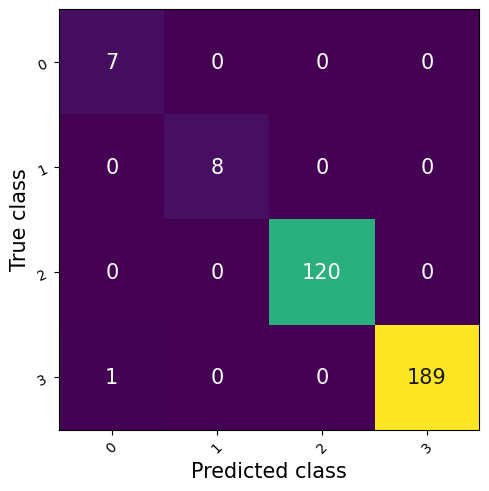

In [93]:
target_train = train_ds.y_data
preds_train  = output_train.argmax(dim=1, keepdim=True).squeeze(1)
metric_train = MulticlassConfusionMatrix(num_classes=4).to(device)
metric_train.update(preds_train, target_train)
fig_, ax_ = metric_train.plot()

In [94]:
metric_collection(preds_train, target_train)

{'MulticlassPrecision': tensor([0.8750, 1.0000, 1.0000, 1.0000], device='cuda:0'),
 'MulticlassRecall': tensor([1.0000, 1.0000, 1.0000, 0.9947], device='cuda:0'),
 'MulticlassF1Score': tensor([0.9333, 1.0000, 1.0000, 0.9974], device='cuda:0')}

### 4-2. Evaluating model with Test Dataset

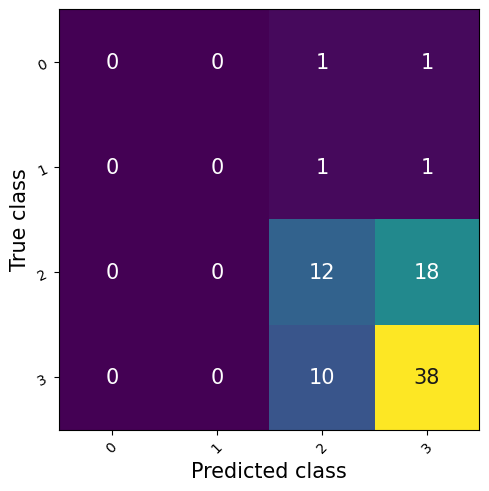

In [95]:
target_test = test_ds.y_data
preds_test  = output_test.argmax(dim=1, keepdim=True).squeeze(1)
metric_test = MulticlassConfusionMatrix(num_classes=4).to(device)
metric_test.update(preds_test, target_test)
fig_, ax_ = metric_test.plot()

In [96]:
metric_collection(preds_test, target_test)

{'MulticlassPrecision': tensor([0.0000, 0.0000, 0.5000, 0.6552], device='cuda:0'),
 'MulticlassRecall': tensor([0.0000, 0.0000, 0.4000, 0.7917], device='cuda:0'),
 'MulticlassF1Score': tensor([0.0000, 0.0000, 0.4444, 0.7170], device='cuda:0')}

## 5. Save model

In [30]:
# 단일 GPU에서 훈련시킨 경우
file_name = "./Model_save/feature3201157_Adam0001s99_ep30_D8_F0_nl3_dr1_new.pt"
T.save(net.state_dict(), file_name)  
print("\ntrained model state saved")


trained model state saved


In [78]:
# 여러 GPU에서 DataParallel로 훈련시키고 나서 weight를 통합해서 저장하는 방법 
# (나중에 불러낸 후 단일 GPU에서 추론 해야만 할 때를 대비하기 위함임) 
file_name = "./Model_save/feature3201157_Adam0001s99_ep30_D8_F0_nl3_dr1_new_multi.pt"
T.save(net.module.state_dict(), file_name)  
print("\ntrained model state saved")


trained model state saved


In [16]:
# load saved model
net = Transformer_Classifier().to(device)
net.load_state_dict(T.load('./Model_save/feature3201157_Adam00001s99_ep31_D8_F0_dr1.pt'))

<All keys matched successfully>

## 6. Visualize the latent space of networks using UMAP

In [65]:
X_Train, X_Train.shape

(array([[206, 172, 195, ...,   0, 148,   0],
        [192, 124, 183, ...,   0, 135,  90],
        [202, 174, 199, ...,   0, 168,   0],
        ...,
        [215, 228, 199, ...,   0, 180,   0],
        [218, 172, 200, ...,   0, 154,   0],
        [218, 201, 201, ..., 152, 158,  95]]),
 (325, 1157))

### 6-1. Analyzing Training dataset

In [66]:
mapper = umap.UMAP().fit(X_Train)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<Axes: >

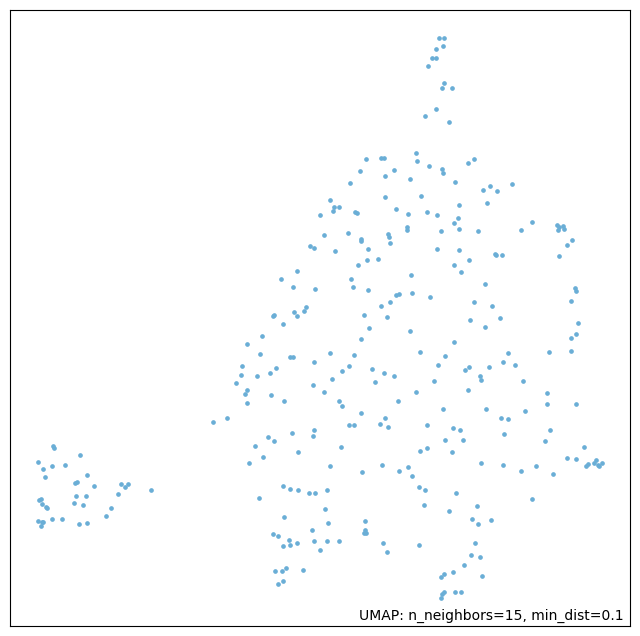

In [67]:
umap.plot.points(mapper)

In [68]:
Y_Train, Y_Train.shape

(array([1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

<Axes: >

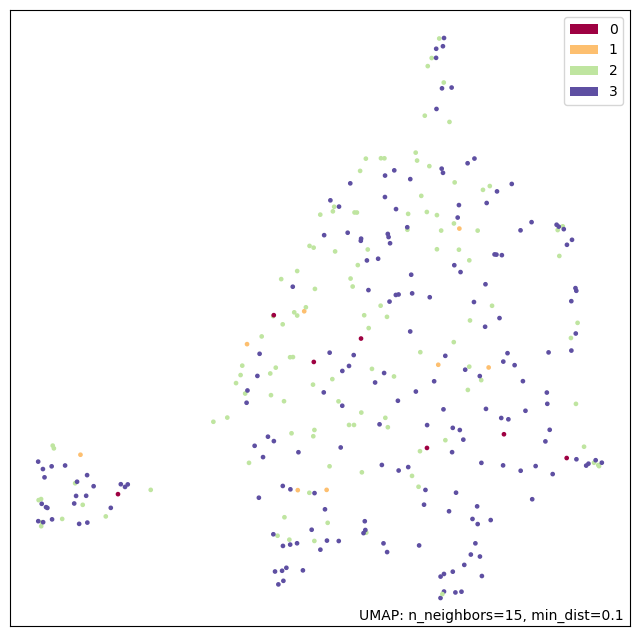

In [69]:
umap.plot.points(mapper, labels=Y_Train)#, theme='darkgreen')
# umap.plot.points(mapper, labels=Y_Train, color_key_cmap='Paired', background='black')

In [70]:
hover_data = pd.DataFrame({'index':np.arange(325),
                           'label':Y_Train})
hover_data['item'] = hover_data.label.map(
    {
        0:'GX',
        1:'G1',
        2:'G2',
        3:'G3',
    }
)
umap.plot.output_notebook()

Loading BokehJS ...

In [71]:
p = umap.plot.interactive(mapper, labels=Y_Train, hover_data=hover_data, point_size=3)
umap.plot.show(p)

invalid value encountered in divide


<Axes: >

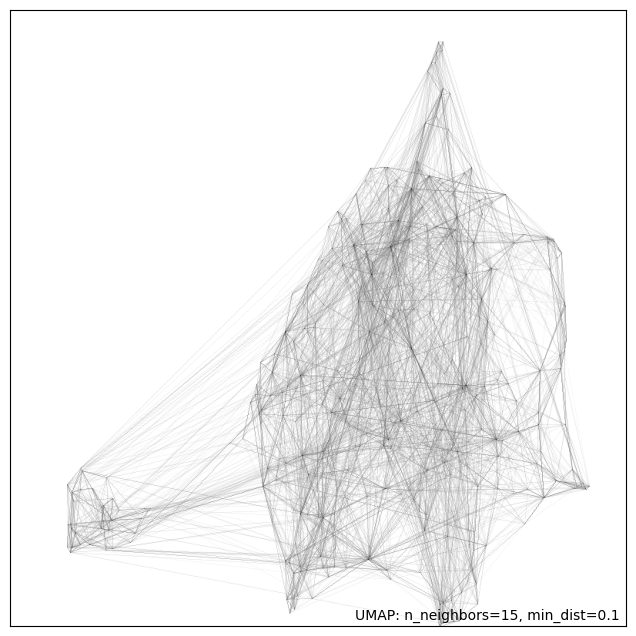

In [72]:
umap.plot.connectivity(mapper, show_points=True)

Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!


<Axes: >

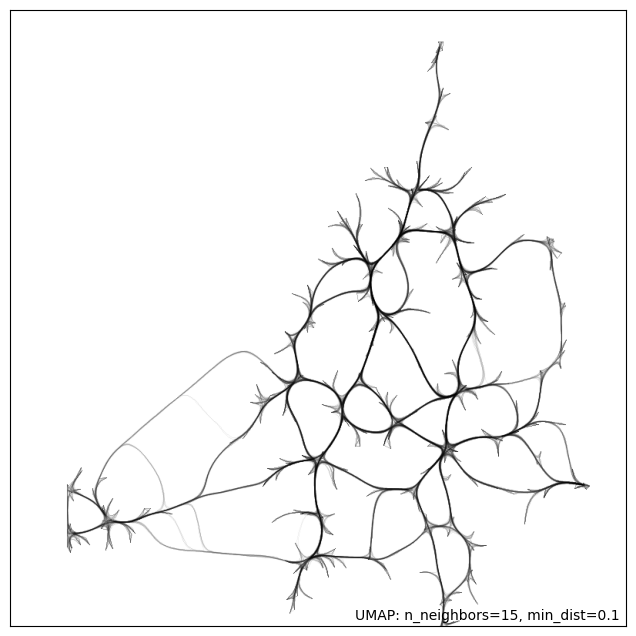

In [73]:
umap.plot.connectivity(mapper, edge_bundling='hammer')

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

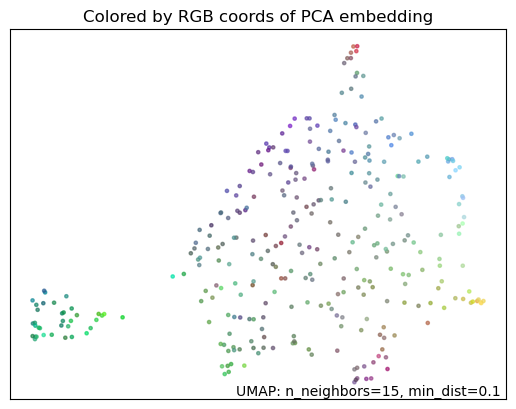

In [74]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


<Axes: title={'center': 'Colored by RGB coords of Vector Quantization'}>

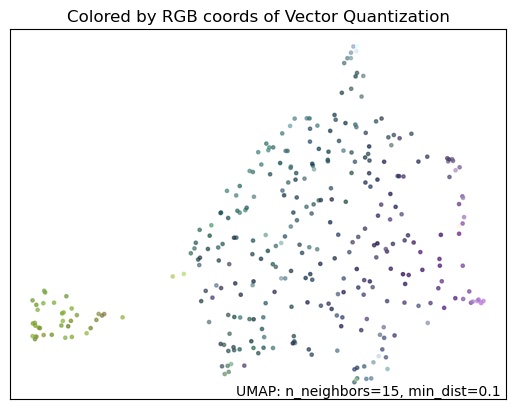

In [75]:
umap.plot.diagnostic(mapper, diagnostic_type='vq')

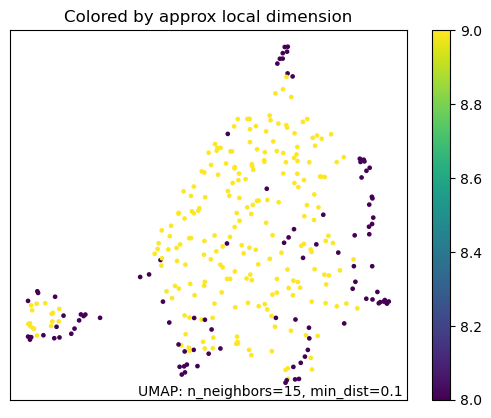

In [76]:
local_dims = umap.plot.diagnostic(mapper, diagnostic_type='local_dim')
# umap.plot.diagnostic(mapper, diagnostic_type='neighborhood')

### 6-2. Compute output of layers of network

In [11]:
# import gc
# net.cpu()
# del net 
# net2.cpu()
# del net2
# gc.collect()
# T.cuda.empty_cache()

##### GPU 1번에는 훈련 안 된 모델, GPU 2번에는 훈련 된 모델 불러오기

In [99]:
net = Transformer_Classifier().to(device)
net.eval()
# load saved model
net2 = Transformer_Classifier().to(device2)
net2.load_state_dict(T.load('./Model_save/feature3201157_Adam00001s99_ep30_D8_F0_nl3_dr1.pt'))               
net2.eval()

Transformer_Classifier(
  (embed): Embedding(320, 8)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (enc_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
    )
    (linear1): Linear(in_features=8, out_features=8, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=8, out_features=8, bias=True)
    (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (trans_enc): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
        )
        (linear1): Linear(in_features=8, out_fe

##### 양쪽 모델에 Train 데이터 넣고 forward 한 다음 각 층을 빼서 numpy로 변환

In [124]:
# 훈련 안 된 모델에 train 데이터 넣어서 forward 
embedded = net.embed(train_ds.x_data)  
z = embedded.reshape(-1, I, D)  
pos_embedded = net.pos_enc(z) 
t_encoded = net.trans_enc(pos_embedded) 
z = t_encoded.reshape(-1, D*I)  
fc3_output = net.fc3(z)
embedded.shape, pos_embedded.shape, t_encoded.shape, fc3_output.shape

(torch.Size([325, 1157, 8]),
 torch.Size([325, 1157, 8]),
 torch.Size([325, 1157, 8]),
 torch.Size([325, 4]))

In [125]:
# 훈련 된 모델에 train 데이터 넣어서 forward 
embedded2 = net2.embed(train_ds2.x_data)  
z = embedded2.reshape(-1, I, D)  
pos_embedded2 = net2.pos_enc(z) 
t_encoded2 = net2.trans_enc(pos_embedded2) 
z = t_encoded2.reshape(-1, D*I)  
fc3_output2 = net2.fc3(z)
embedded2.shape, pos_embedded2.shape, t_encoded2.shape, fc3_output2.shape

(torch.Size([325, 1157, 8]),
 torch.Size([325, 1157, 8]),
 torch.Size([325, 1157, 8]),
 torch.Size([325, 4]))

In [126]:
# Train 데이터로 추론한 모델 각 층의 numpy 데이터
n_sample = 325 
embedded_before = embedded.detach().cpu().numpy().reshape(n_sample, -1)
embedded_after = embedded2.detach().cpu().numpy().reshape(n_sample, -1)
pos_embedded_before = pos_embedded.detach().cpu().numpy().reshape(n_sample, -1)
pos_embedded_after = pos_embedded2.detach().cpu().numpy().reshape(n_sample, -1)
t_encoded_before = t_encoded.detach().cpu().numpy().reshape(n_sample, -1)
t_encoded_after = t_encoded2.detach().cpu().numpy().reshape(n_sample, -1)
fc3_output_before = fc3_output.detach().cpu().numpy()
fc3_output_after = fc3_output2.detach().cpu().numpy()
embedded_after.shape, pos_embedded_after.shape, t_encoded_after.shape, fc3_output_after.shape

((325, 9256), (325, 9256), (325, 9256), (325, 4))

##### 양쪽 모델에 Test 데이터 넣고 forward 한 다음 각 층을 빼서 numpy로 변환

In [111]:
# 훈련 안 된 모델에 test 데이터 넣어서 forward 
embedded = net.embed(test_ds.x_data)  
z = embedded.reshape(-1, I, D)  
pos_embedded = net.pos_enc(z) 
t_encoded = net.trans_enc(pos_embedded) 
z = t_encoded.reshape(-1, D*I)  
fc3_output = net.fc3(z)
embedded.shape, pos_embedded.shape, t_encoded.shape, fc3_output.shape

(torch.Size([82, 1157, 8]),
 torch.Size([82, 1157, 8]),
 torch.Size([82, 1157, 8]),
 torch.Size([82, 4]))

In [112]:
# 훈련 된 모델에 test 데이터 넣어서 forward 
embedded2 = net2.embed(test_ds2.x_data)  
z = embedded2.reshape(-1, I, D)  
pos_embedded2 = net2.pos_enc(z) 
t_encoded2 = net2.trans_enc(pos_embedded2) 
z = t_encoded2.reshape(-1, D*I)  
fc3_output2 = net2.fc3(z)
embedded2.shape, pos_embedded2.shape, t_encoded2.shape, fc3_output2.shape

(torch.Size([82, 1157, 8]),
 torch.Size([82, 1157, 8]),
 torch.Size([82, 1157, 8]),
 torch.Size([82, 4]))

In [113]:
# Test 데이터로 추론한 모델 각 층의 numpy 데이터
n_sample = 82
embedded_before = embedded[:,:,0].detach().cpu().numpy().reshape(n_sample, -1)
embedded_after = embedded2[:,:,0].detach().cpu().numpy().reshape(n_sample, -1)
pos_embedded_before = pos_embedded[:,:,0].detach().cpu().numpy().reshape(n_sample, -1)
pos_embedded_after = pos_embedded2[:,:,0].detach().cpu().numpy().reshape(n_sample, -1)
t_encoded_before = t_encoded[:,:,0].detach().cpu().numpy().reshape(n_sample, -1)
t_encoded_after = t_encoded2[:,:,0].detach().cpu().numpy().reshape(n_sample, -1)
fc3_output_before = fc3_output.detach().cpu().numpy()
fc3_output_after = fc3_output2.detach().cpu().numpy()
embedded_after.shape, pos_embedded_after.shape, t_encoded_after.shape, fc3_output_after.shape

((82, 1157), (82, 1157), (82, 1157), (82, 4))

### 6-3. Visualizing network

In [127]:
embedded_mapper_before = umap.UMAP().fit(embedded_before)
embedded_mapper_after = umap.UMAP().fit(embedded_after)

Uembedding_embedded_before = embedded_mapper_before.transform(embedded_before)
Uembedding_embedded_after = embedded_mapper_after.transform(embedded_after)

In [128]:
pos_embedded_mapper_before = umap.UMAP().fit(pos_embedded_before)
pos_embedded_mapper_after = umap.UMAP().fit(pos_embedded_after)

Uembedding_pos_embedded_before = pos_embedded_mapper_before.transform(pos_embedded_before)
Uembedding_pos_embedded_after = pos_embedded_mapper_after.transform(pos_embedded_after)

In [129]:
t_encoded_mapper_before = umap.UMAP().fit(t_encoded_before)
t_encoded_mapper_after = umap.UMAP().fit(t_encoded_after)

Uembedding_t_encoded_before = t_encoded_mapper_before.transform(t_encoded_before)
Uembedding_t_encoded_after = t_encoded_mapper_after.transform(t_encoded_after)

In [133]:
fc3_output_mapper_before = umap.UMAP().fit(fc3_output_before)
fc3_output_mapper_after = umap.UMAP().fit(fc3_output_after)

Uembedding_fc3_output_before = fc3_output_mapper_before.transform(fc3_output_before)
Uembedding_fc3_output_after = fc3_output_mapper_after.transform(fc3_output_after)

#### 6-3-1. Embdding layer before & after training

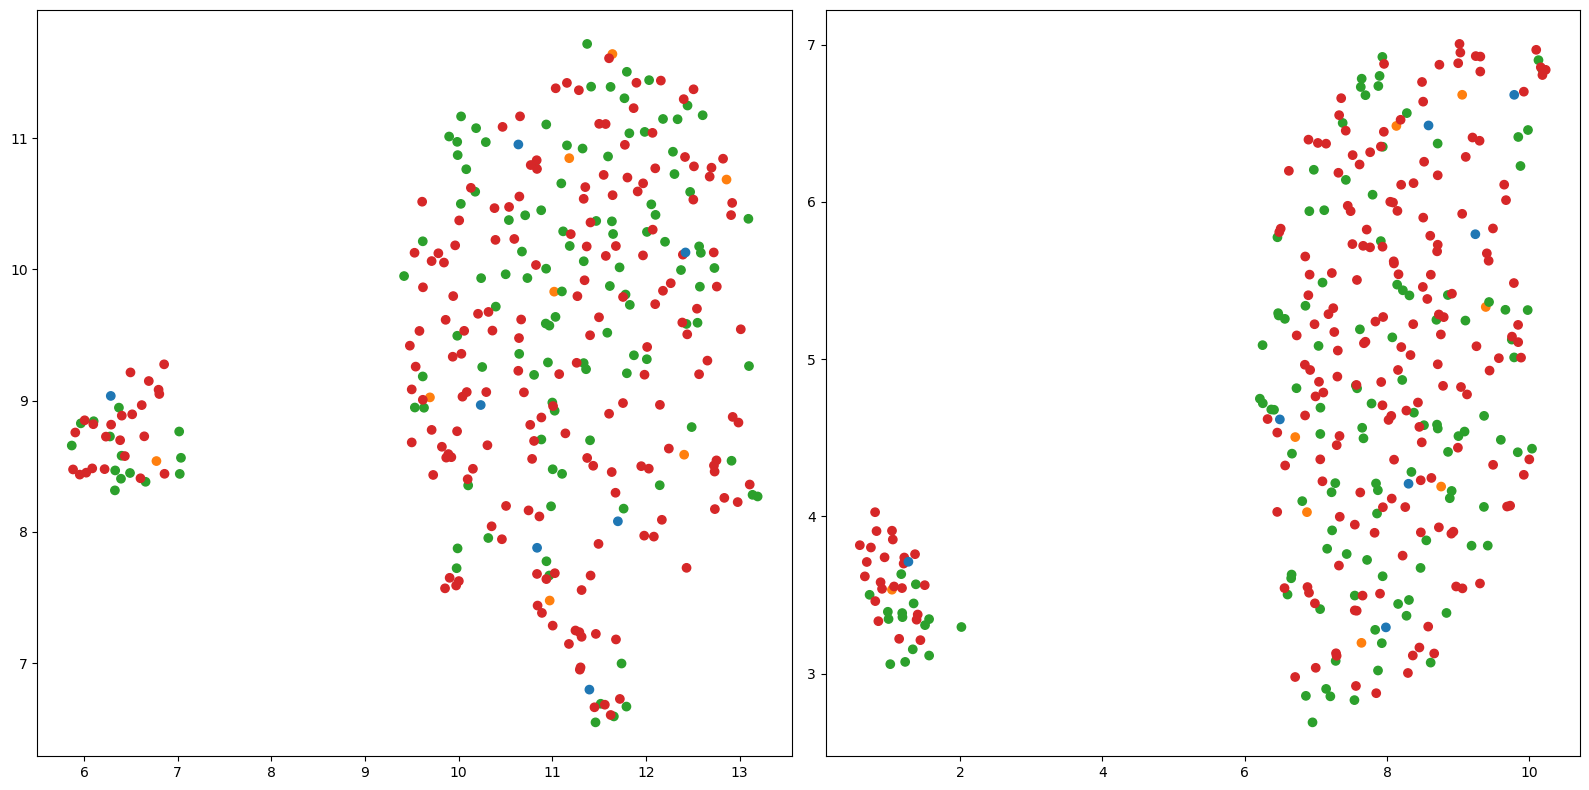

In [107]:
# Train set 으로
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_embedded_before[:, 0], Uembedding_embedded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
axes[1].scatter(Uembedding_embedded_after[:, 0], Uembedding_embedded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
plt.tight_layout()
plt.show()
plt.close(fig)

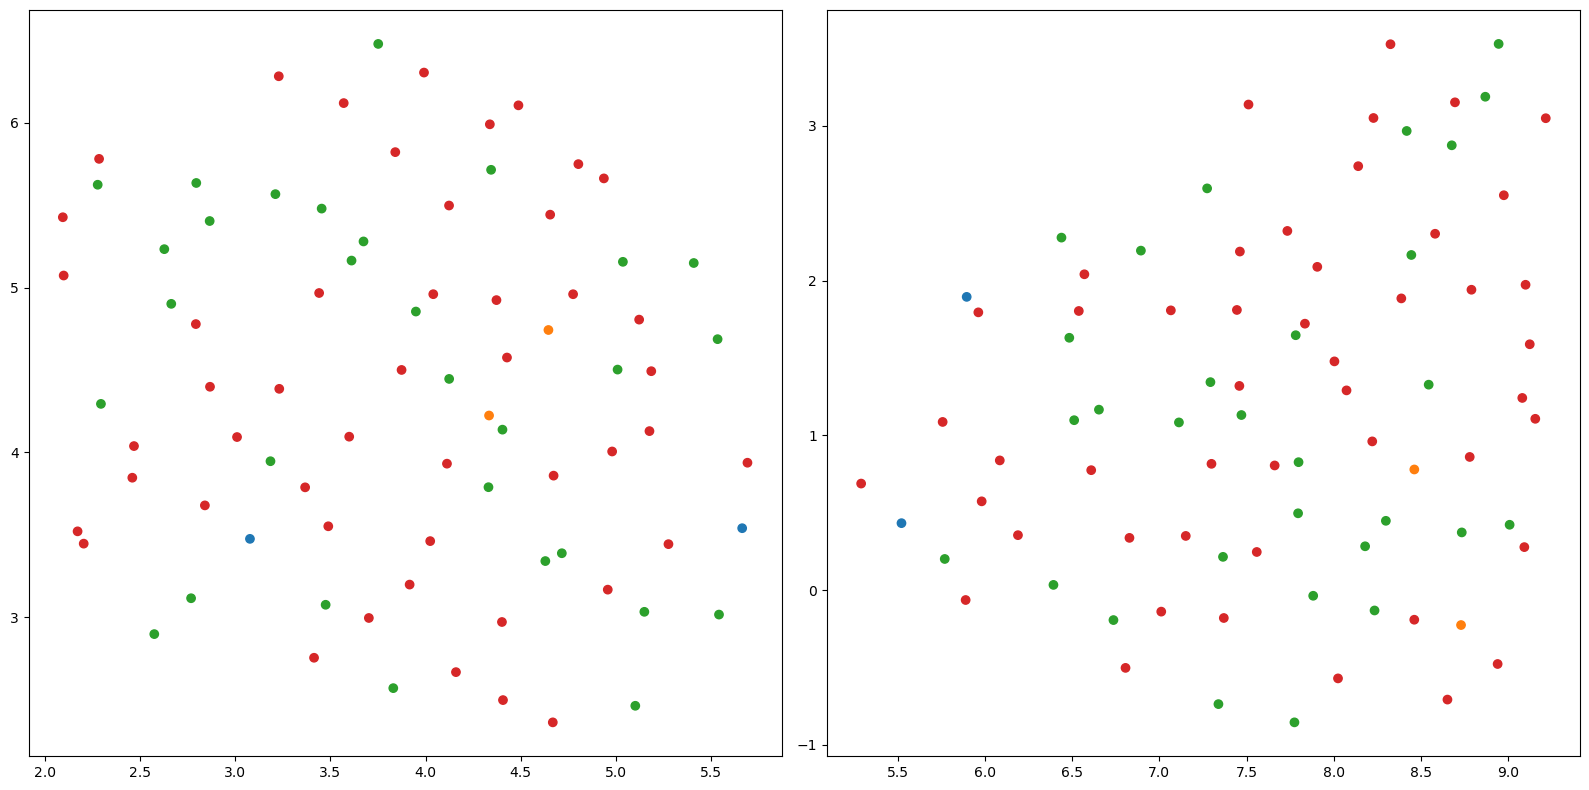

In [119]:
# Test set 으로
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_embedded_before[:, 0], Uembedding_embedded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
axes[1].scatter(Uembedding_embedded_after[:, 0], Uembedding_embedded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
plt.tight_layout()
plt.show()
plt.close(fig)

#### 6-3-2. Positional Embdding layer before & after training

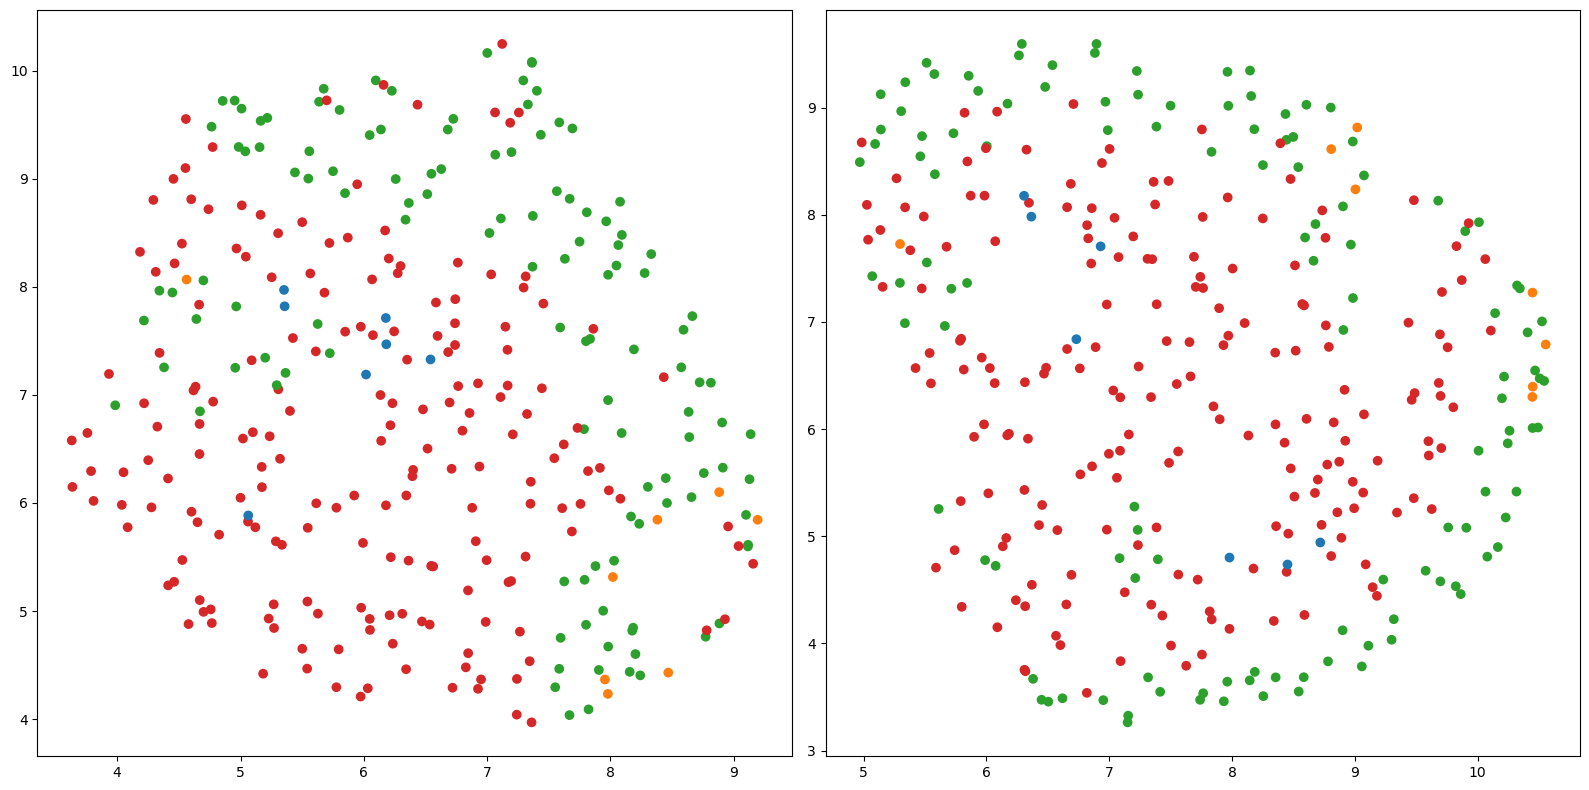

In [108]:
# Train set 으로
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_pos_embedded_before[:, 0], Uembedding_pos_embedded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
axes[1].scatter(Uembedding_pos_embedded_after[:, 0], Uembedding_pos_embedded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
plt.tight_layout()
plt.show()
plt.close(fig)

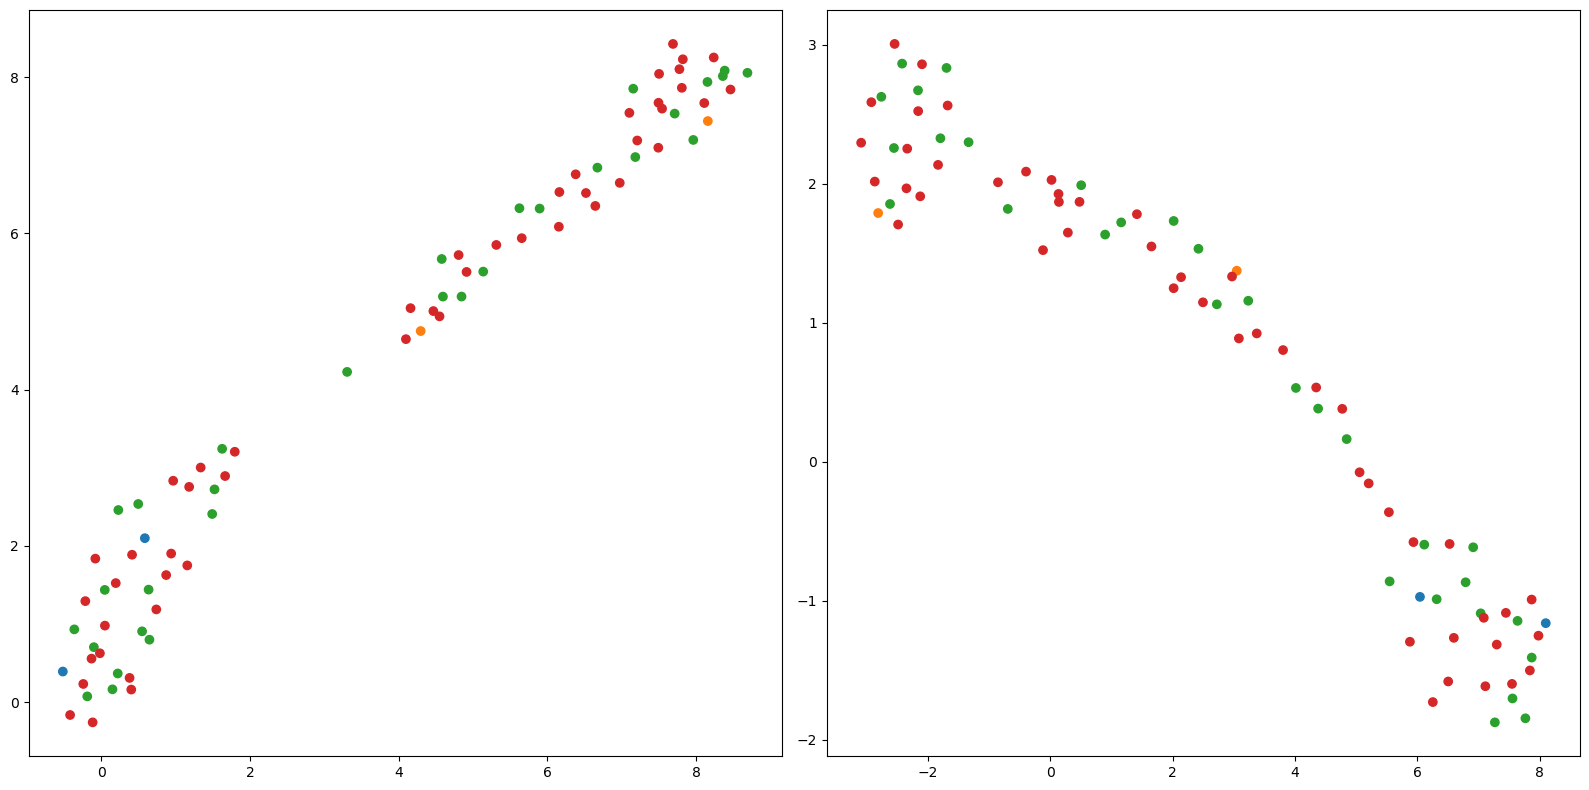

In [120]:
# Test set 으로
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_pos_embedded_before[:, 0], Uembedding_pos_embedded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
axes[1].scatter(Uembedding_pos_embedded_after[:, 0], Uembedding_pos_embedded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
plt.tight_layout()
plt.show()
plt.close(fig)

#### 6-3-3. Transformer Encoder before & after training

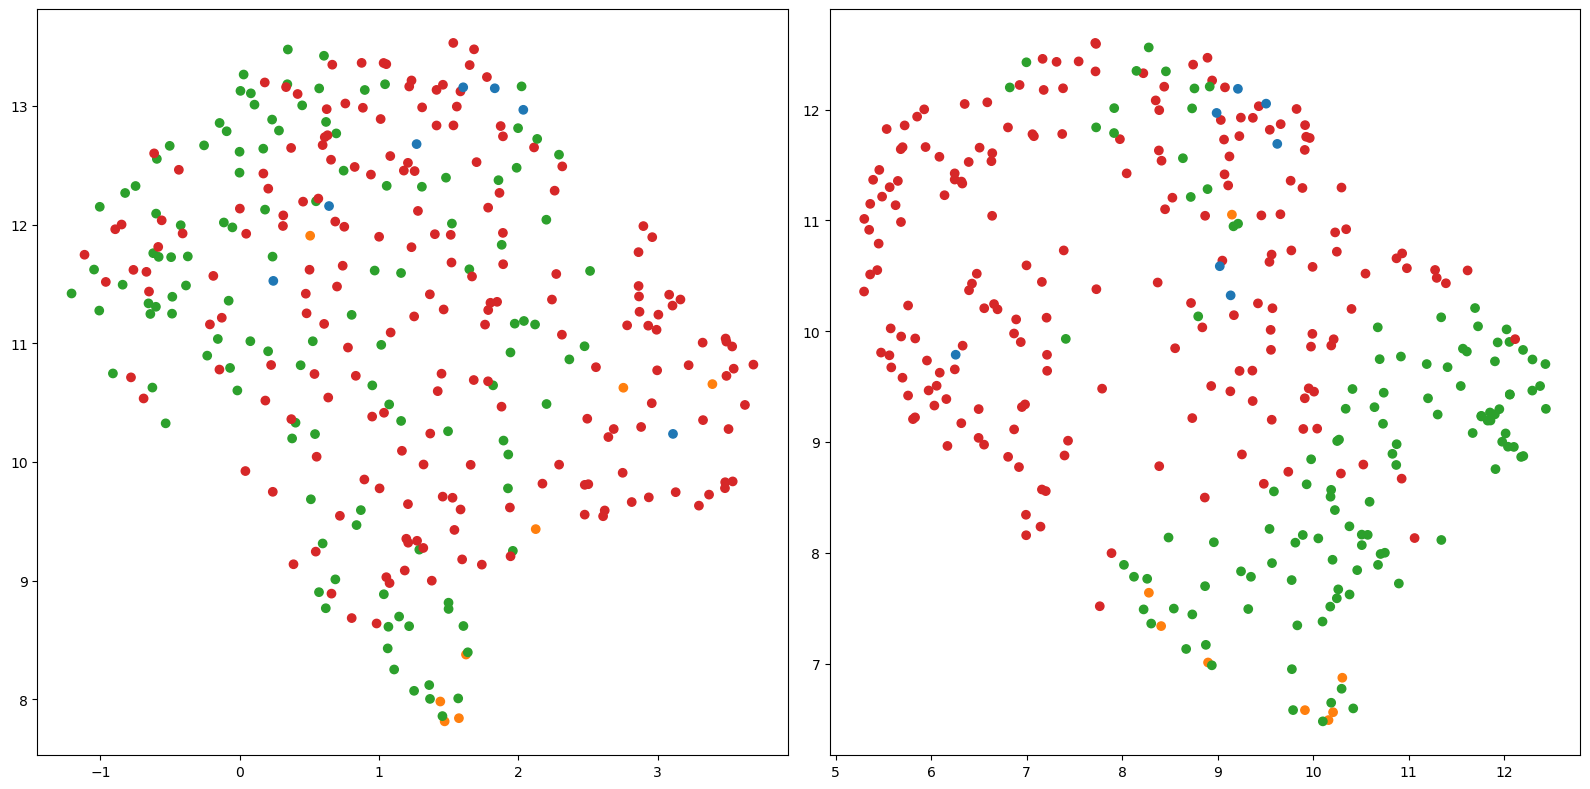

In [109]:
# Train Set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_t_encoded_before[:, 0], Uembedding_t_encoded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
axes[1].scatter(Uembedding_t_encoded_after[:, 0], Uembedding_t_encoded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
plt.tight_layout()
plt.show()
plt.close(fig)

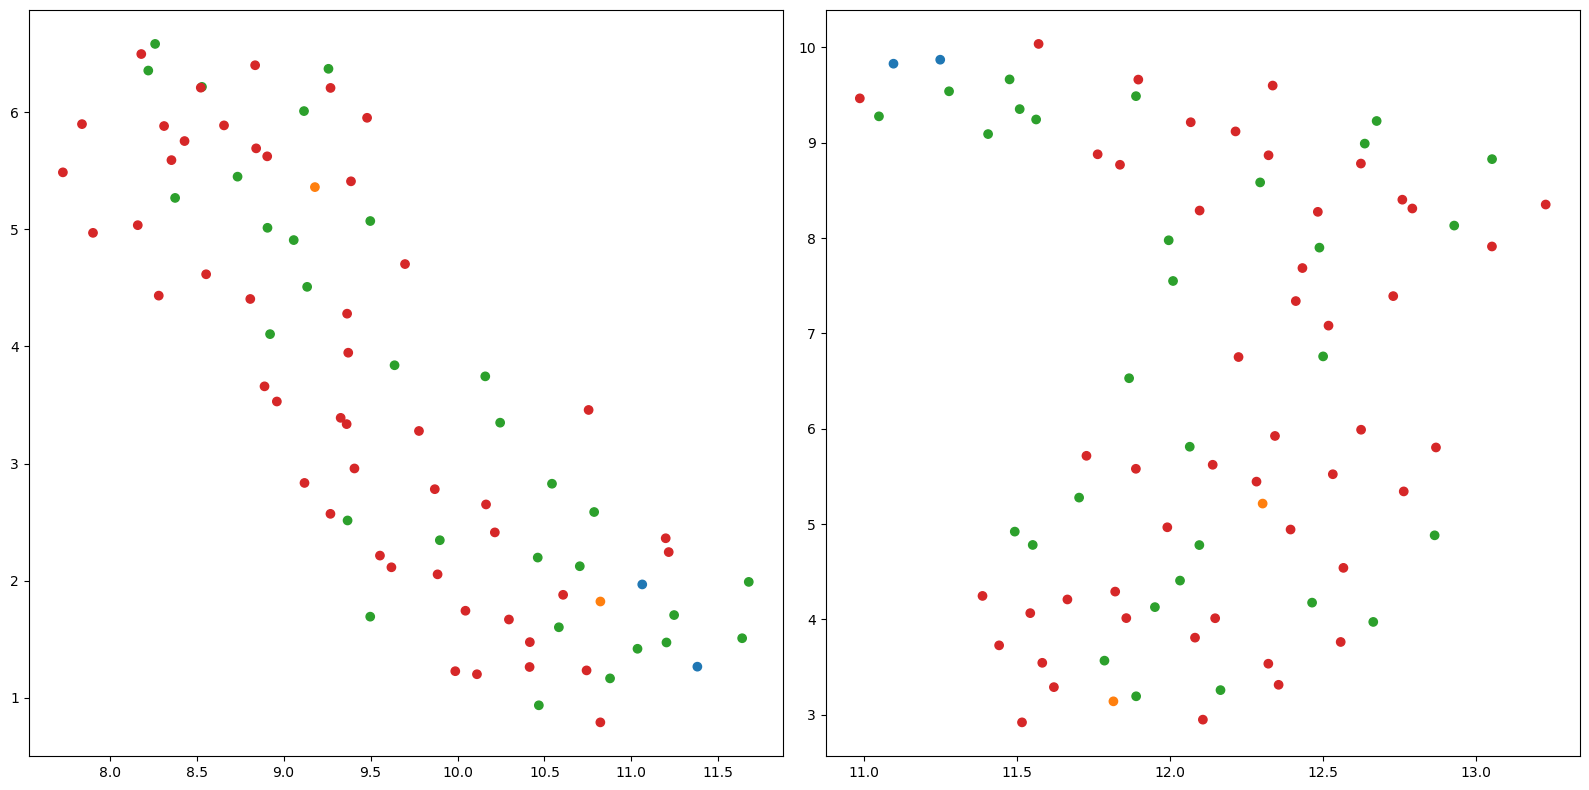

In [121]:
# Test Set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_t_encoded_before[:, 0], Uembedding_t_encoded_before[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
axes[1].scatter(Uembedding_t_encoded_after[:, 0], Uembedding_t_encoded_after[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
plt.tight_layout()
plt.show()
plt.close(fig)

#### 6-3-4. Fully-Connected Layer1 before & after training

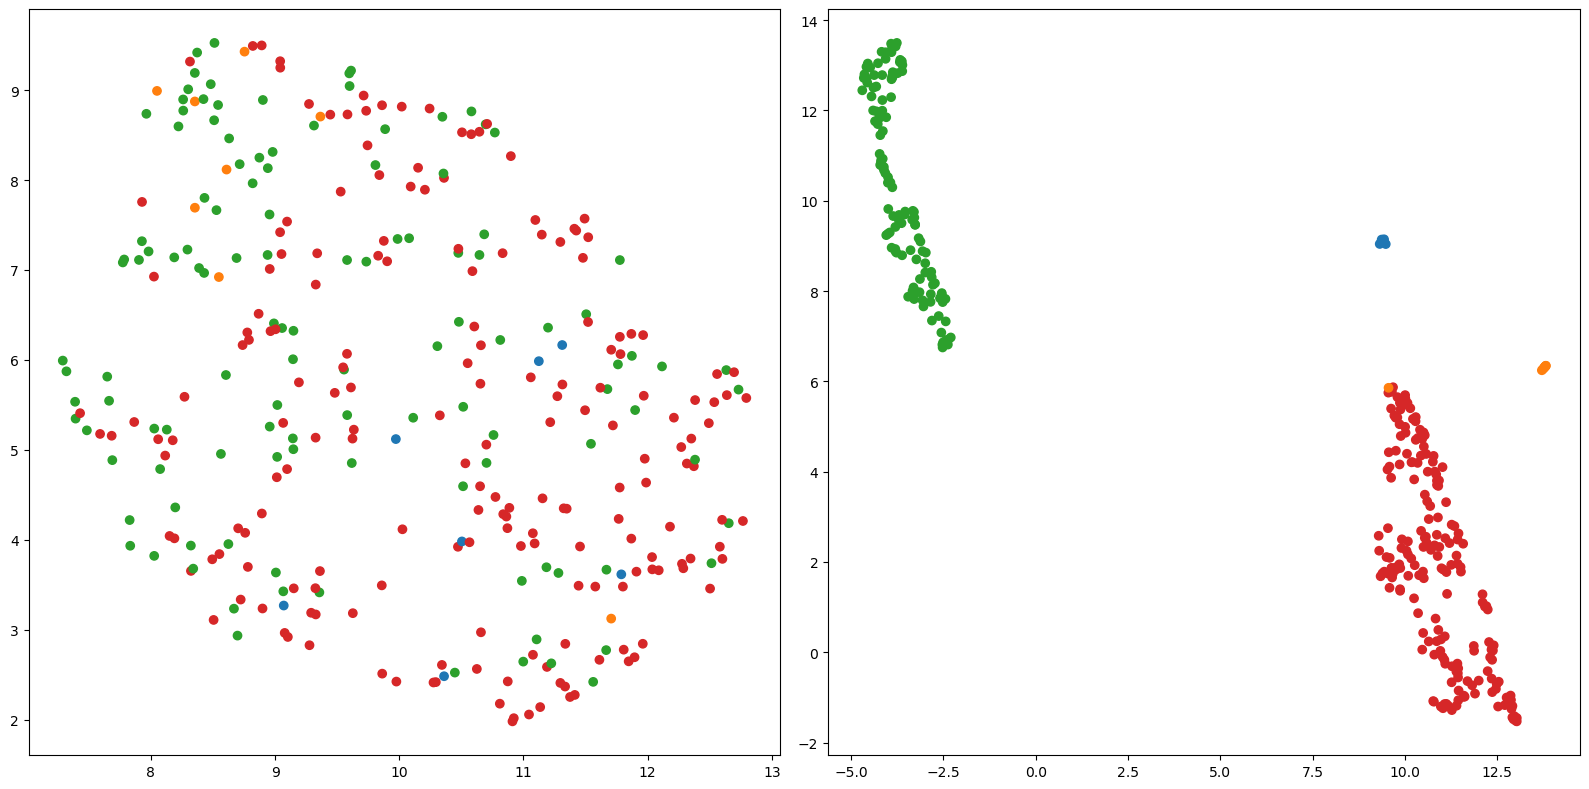

In [110]:
# Train Set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_fc3_output_before[:, 0], Uembedding_fc3_output_before[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
axes[1].scatter(Uembedding_fc3_output_after[:, 0], Uembedding_fc3_output_after[:, 1], c=[sns.color_palette()[x] for x in Y_Train])
plt.tight_layout()
plt.show()
plt.close(fig)

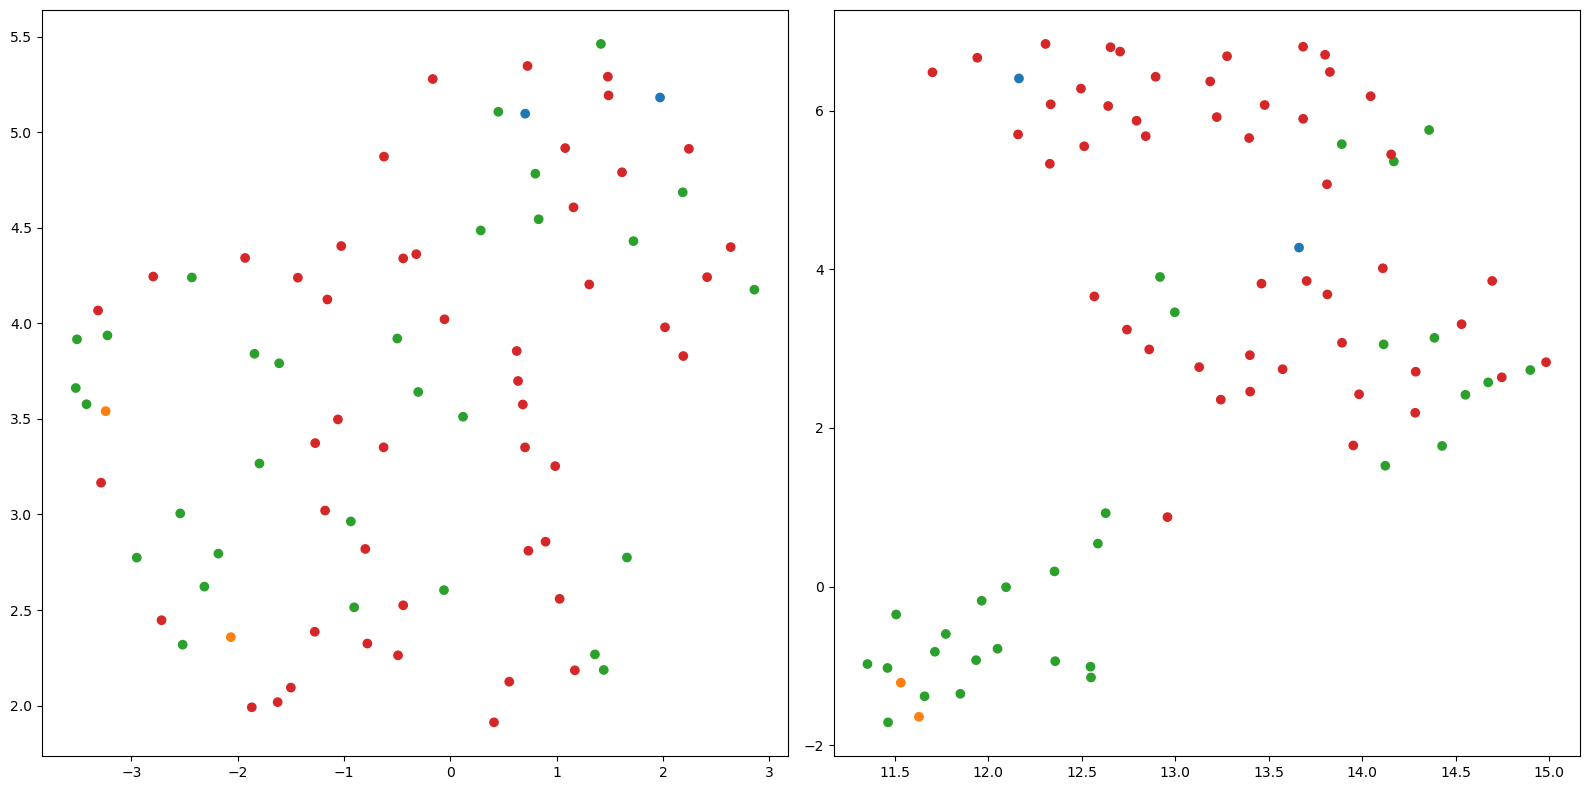

In [122]:
# Test Set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axes[0].scatter(Uembedding_fc3_output_before[:, 0], Uembedding_fc3_output_before[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
axes[1].scatter(Uembedding_fc3_output_after[:, 0], Uembedding_fc3_output_after[:, 1], c=[sns.color_palette()[x] for x in Y_Test])
plt.tight_layout()
plt.show()
plt.close(fig)

In [134]:
# FC2 Layer 들어가기 전의 데이터에서 세부사항 확인해 보기 
# (index가 나오므로 이것으로 어느 유전자인지 역추적 가능할 것임)
hover_data = pd.DataFrame({'index':np.arange(325),
                           'label':Y_Train})
hover_data['item'] = hover_data.label.map(
    {
        0:'GX',
        1:'G1',
        2:'G2',
        3:'G3',
    }
)
umap.plot.output_notebook()
p = umap.plot.interactive(fc3_output_mapper_after, labels=Y_Train, hover_data=hover_data, point_size=4)
umap.plot.show(p)

Loading BokehJS ...

## 7. Analizing the degree of contribution of each feature using SHAP

In [8]:
def MinMax(X):
    X_norm = (X-np.min(X)) / (np.max(X)-np.min(X))
    return X_norm

In [91]:
# np.set_printoptions(threshold=np.inf, linewidth=90)
# np.set_printoptions(threshold=1000, linewidth=90)
# np.seterr(divide='warn', invalid='warn')

##### 트랜스포머 인코더가 인식하는 feature 번호가 어떤 유전자ID인지 참조할 수 있는 리스트 만들기

In [13]:
df = pd.read_pickle('xy_STAD-related-only2.pkl')
df

,submitter_id.samples,neoplasm_histologic_grade,ENSG00000092621.10,ENSG00000134982.15,ENSG00000132781.16,ENSG00000125347.12,ENSG00000003400.13,ENSG00000133703.10,ENSG00000141736.12,ENSG00000066468.19,...,ENSG00000065154.10,ENSG00000140374.14,ENSG00000113649.10,ENSG00000122692.8,ENSG00000146205.12,ENSG00000139636.14,ENSG00000136436.13,ENSG00000115541.9,ENSG00000187555.13,ENSG00000186868.14
0,TCGA-3M-AB46-01A,G2,17.251112,15.079514,17.414938,17.365214,18.054834,17.592039,19.026159,16.988659,...,19.971286,17.520186,17.608391,16.934600,12.232790,15.882418,19.502006,21.471786,19.033745,11.708090
1,TCGA-3M-AB47-01A,G3,14.407931,16.812603,15.904570,18.298847,17.441156,18.036434,17.735773,16.097251,...,18.042885,18.507986,17.605038,17.802902,11.774955,16.386493,18.738287,20.527855,18.332285,10.845279
2,TCGA-B7-5818-01A,G3,13.235416,15.642202,15.912011,18.662111,16.382809,17.797608,19.516644,19.218607,...,18.962656,18.201000,16.951647,17.390941,10.842400,15.912461,18.733346,20.074926,18.111386,9.361220
3,TCGA-B7-A5TI-01A,G3,16.119779,16.060210,16.614935,16.654159,16.730176,17.937752,19.660434,18.737403,...,19.952706,18.530013,17.372864,17.726900,14.901840,15.671850,18.536612,20.684934,18.679611,10.459951
4,TCGA-B7-A5TJ-01A,G1,16.702316,15.719877,16.525847,17.006665,16.876615,17.559441,18.943163,17.838738,...,18.358425,18.338826,17.444754,17.045052,15.390480,16.549372,17.743944,20.391893,18.815926,9.941481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,TCGA-VQ-AA6G-01A,G2,17.216473,17.333125,16.562825,18.292577,19.014720,18.792734,24.963099,15.413158,...,18.727258,18.505930,17.696179,17.312959,15.179511,16.085758,18.788913,20.277917,18.388399,8.246315
403,TCGA-VQ-AA6J-01A,G3,19.585174,16.254265,16.554167,18.734580,17.640446,17.564258,18.318130,16.909481,...,18.491928,17.980797,17.575003,16.999468,14.597397,16.231806,18.553040,20.290658,18.246014,11.735346
404,TCGA-VQ-AA6K-01A,G3,16.326261,16.784325,15.890133,18.029975,17.364764,18.153768,19.371017,16.453277,...,19.215405,18.157770,17.974813,17.032425,13.952300,16.112822,18.251106,19.949184,18.958449,10.287439
405,TCGA-ZA-A8F6-01A,G2,16.193348,16.693416,16.193612,17.997426,17.702167,17.058265,19.367424,16.519393,...,20.106597,17.977469,17.021629,17.271290,12.360294,16.482036,18.290664,19.654904,18.268252,14.064136


In [14]:
gene_ids_trimmed = [gene_id[:15] for gene_id in df.columns[2:]]
for original, trimmed in zip(df.columns[2:], gene_ids_trimmed):
    df.rename(columns={original:trimmed}, inplace=True)
dfs = df.sort_index(axis=1)
dfs

,ENSG00000001036,ENSG00000001626,ENSG00000002330,ENSG00000003400,ENSG00000003402,ENSG00000005175,ENSG00000006831,ENSG00000007038,ENSG00000007062,ENSG00000007171,...,ENSG00000278910,ENSG00000280924,ENSG00000280997,ENSG00000281183,ENSG00000281189,ENSG00000281202,ENSG00000281406,ENSG00000281450,neoplasm_histologic_grade,submitter_id.samples
0,20.220979,14.665292,18.727956,18.054834,16.883271,17.925067,17.770933,17.075150,19.532668,12.899567,...,9.415178,13.167983,0.000000,13.485292,13.578557,0.000000,15.438352,8.090678,G2,TCGA-3M-AB46-01A
1,18.500387,18.794606,18.090443,17.441156,17.084666,16.966393,17.911313,17.918745,17.848073,20.369232,...,10.799621,11.281136,0.000000,14.944210,11.546818,0.000000,12.354517,8.889208,G3,TCGA-3M-AB47-01A
2,19.761280,19.947795,19.709574,16.382809,17.009260,16.450929,18.338054,0.000000,19.286103,15.615647,...,11.088938,14.599826,8.546172,12.620040,13.064786,0.000000,15.455768,9.762250,G3,TCGA-B7-5818-01A
3,19.181518,10.613326,18.942790,16.730176,17.504471,16.700315,18.743804,13.404958,19.960137,14.335578,...,10.703615,13.796031,7.579382,13.917905,11.974194,0.000000,16.328196,0.000000,G3,TCGA-B7-A5TI-01A
4,19.586652,17.520498,18.527097,16.876615,16.508963,17.002714,18.322003,12.930491,18.587707,14.618427,...,10.185077,12.604413,10.960521,14.445830,12.838448,9.294717,16.457270,0.000000,G1,TCGA-B7-A5TJ-01A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,18.996392,16.725651,17.717748,19.014720,17.760508,16.808091,18.895264,11.843199,18.821252,20.924100,...,8.973679,13.890051,7.433210,14.811144,12.551461,0.000000,15.849008,9.230485,G2,TCGA-VQ-AA6G-01A
403,18.794649,17.282670,17.603730,17.640446,17.107674,16.958818,17.772747,12.009924,17.793565,16.328723,...,10.099362,14.217296,8.969995,14.709362,13.369268,0.000000,15.227504,9.187872,G3,TCGA-VQ-AA6J-01A
404,19.295330,18.157491,17.706194,17.364764,17.483705,16.245028,18.701045,11.352034,19.956168,13.972806,...,11.649856,11.868503,10.104749,15.562842,12.255207,0.000000,17.192497,8.740135,G3,TCGA-VQ-AA6K-01A
405,18.647983,17.995544,18.393344,17.702167,17.343445,16.528308,18.016156,14.130838,18.504918,19.475805,...,10.215577,11.918873,0.000000,15.733577,12.591478,0.000000,14.480349,0.000000,G2,TCGA-ZA-A8F6-01A


In [15]:
STAD_related_geneID_list = dfs.columns[:-2]
STAD_related_geneID_list

Index(['ENSG00000001036', 'ENSG00000001626', 'ENSG00000002330',
       'ENSG00000003400', 'ENSG00000003402', 'ENSG00000005175',
       'ENSG00000006831', 'ENSG00000007038', 'ENSG00000007062',
       'ENSG00000007171',
       ...
       'ENSG00000278637', 'ENSG00000278705', 'ENSG00000278910',
       'ENSG00000280924', 'ENSG00000280997', 'ENSG00000281183',
       'ENSG00000281189', 'ENSG00000281202', 'ENSG00000281406',
       'ENSG00000281450'],
      dtype='object', length=1157)

##### 위 리스트의 gene ID에 상응하는 gene symbol 리스트 만들기

In [16]:
df = pd.read_excel('STAD_related_gene_ensenblID_1202.xlsx')
df

,Gene Symbol,Ensembl ID,Gene Symbol_not_found
0,PHGDH,ENSG00000092621,RAD51L3-RFFL
1,APC,ENSG00000134982,LOC126862571
2,MUTYH,ENSG00000132781,LOC126860438
3,IRF1,ENSG00000125347,LOC130001603
4,CASP10,ENSG00000003400,LOC130062899
...,...,...,...
1180,LMBR1L,ENSG00000139636,NaN
1181,CALCOCO2,ENSG00000136436,NaN
1182,HSPE1,ENSG00000115541,NaN
1183,USP7,ENSG00000187555,NaN


In [17]:
df['Gene Symbol']

0          PHGDH
1            APC
2          MUTYH
3           IRF1
4         CASP10
          ...   
1180      LMBR1L
1181    CALCOCO2
1182       HSPE1
1183        USP7
1184        MAPT
Name: Gene Symbol, Length: 1185, dtype: object

In [18]:
df['Gene Symbol'][0]

'PHGDH'

In [19]:
STAD_related_gene_symbol_list = []
for gene_ID in STAD_related_geneID_list:
    for i, E_ID in enumerate(df['Ensembl ID']):
        if gene_ID == E_ID:
            STAD_related_gene_symbol_list.append(df['Gene Symbol'][i])
len(STAD_related_gene_symbol_list)

1157

### 7-1. Deep Explainer

In [60]:
model = Transformer_Classifier().to(device)
model.load_state_dict(T.load('./Model_save/feature3201157_Adam0001s99_ep30_D8_F0_nl3_dr1_new.pt'))

<All keys matched successfully>

In [62]:
batchsize = 1
torchinfo.summary(model, input_size=(batchsize, 1157),  dtypes=[T.long],
col_names=["input_size","output_size","num_params","params_percent","trainable"])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Param %                   Trainable
Transformer_Classifier                        [1, 1157]                 [1, 4]                    464                         1.12%                   True
├─Embedding: 1-1                              [1, 1157]                 [1, 1157, 8]              2,560                       6.18%                   True
├─PositionalEncoding: 1-2                     [1, 1157, 8]              [1, 1157, 8]              --                             --                   --
│    └─Dropout: 2-1                           [1, 1157, 8]              [1, 1157, 8]              --                             --                   --
├─TransformerEncoder: 1-3                     [1, 1157, 8]              [1, 1157, 8]              --                             --                   True
│    └─ModuleList: 2-2                        --                     

In [47]:
# model.train()
# de = shap.DeepExplainer(f, model.embed(train_ds.x_data))
# de = shap.DeepExplainer(f, MinMax(X_Train_SHAP_zero_replaced)[0:325])
de = shap.DeepExplainer((model, model.trans_enc) , train_ds.x_data[114:279])

In [50]:
D_shap_values = de.shap_values(train_ds.x_data[110:115], check_additivity=False)

In [78]:
len(D_shap_values), D_shap_values[3].shape, D_shap_values[3][1].shape, D_shap_values[3][1].T.shape

(4, (2, 1157, 8), (1157, 8), (8, 1157))

In [51]:
np.sum(D_shap_values[2][2])

-1.088535735245614

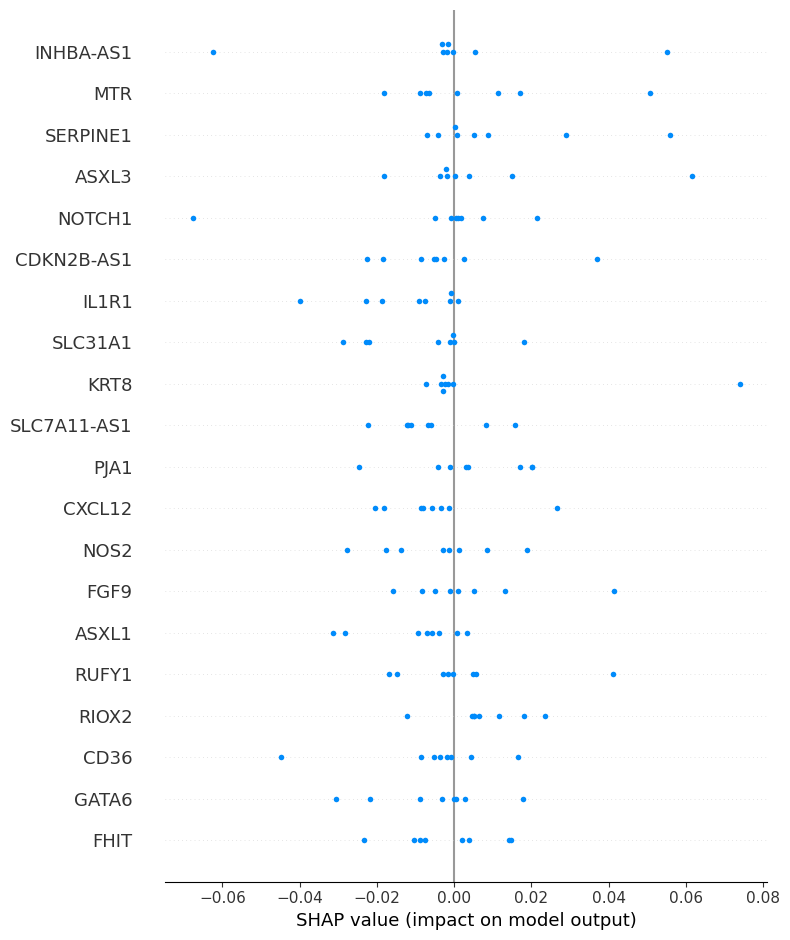

In [52]:
shap.summary_plot(D_shap_values[2][2].T, features=STAD_related_gene_symbol_list)

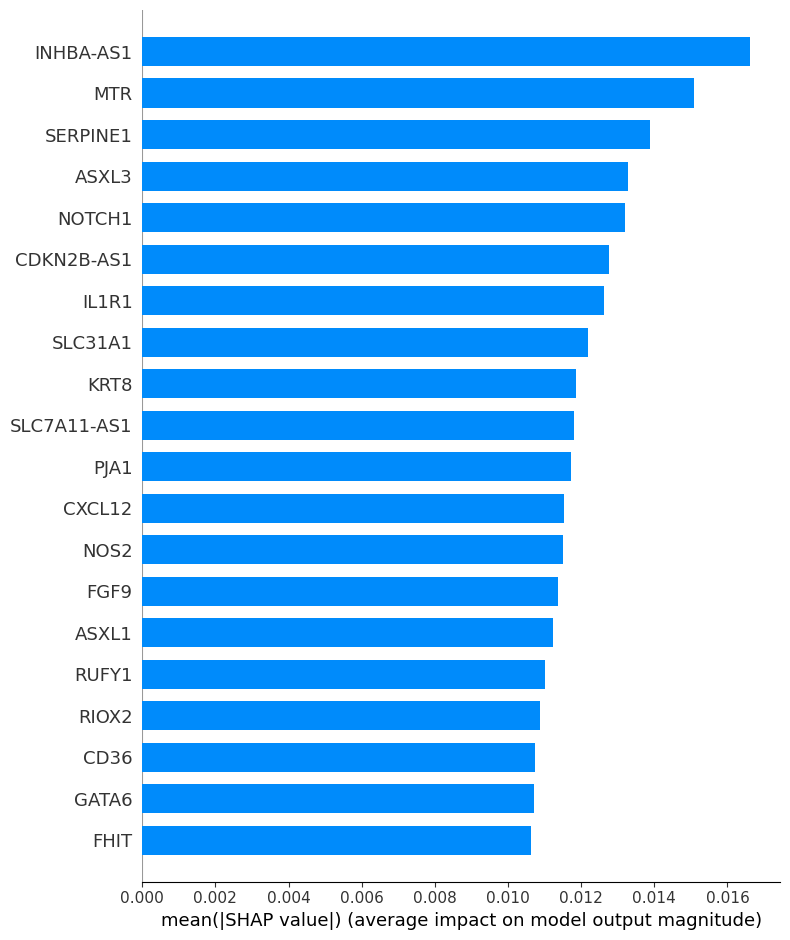

In [57]:
shap.summary_plot(D_shap_values[2][2].T, plot_type='bar', features=STAD_related_gene_symbol_list)

In [82]:
STAD_related_geneID_list[1018], STAD_related_geneID_list[635], STAD_related_geneID_list[336], STAD_related_geneID_list[598]

('ENSG00000224116', 'ENSG00000155269', 'ENSG00000116984', 'ENSG00000148400')

### 7-2. Gradient Explainer

In [8]:
model = Transformer_Classifier().to(device)
model.load_state_dict(T.load('./Model_save/feature3201157_Adam0001s99_ep30_D8_F0_nl3_dr1_new.pt'))

<All keys matched successfully>

In [10]:
# from torch.autograd import grad as original_grad

# def new_grad(*args, **kwargs):
#     kwargs['allow_unused'] = True

#     return original_grad(*args, **kwargs)

# T.autograd.grad = new_grad

In [9]:
# model.train()
ge = shap.GradientExplainer((model, model.trans_enc), train_ds.x_data)

In [10]:
G_shap_values = ge.shap_values(train_ds.x_data[110:115])

In [11]:
np.sum(G_shap_values[2][2])

-0.17837275396576718

In [96]:
len(G_shap_values), G_shap_values[3].shape, G_shap_values[3][1].shape, G_shap_values[3][1].T.shape

(4, (5, 1157, 8), (1157, 8), (8, 1157))

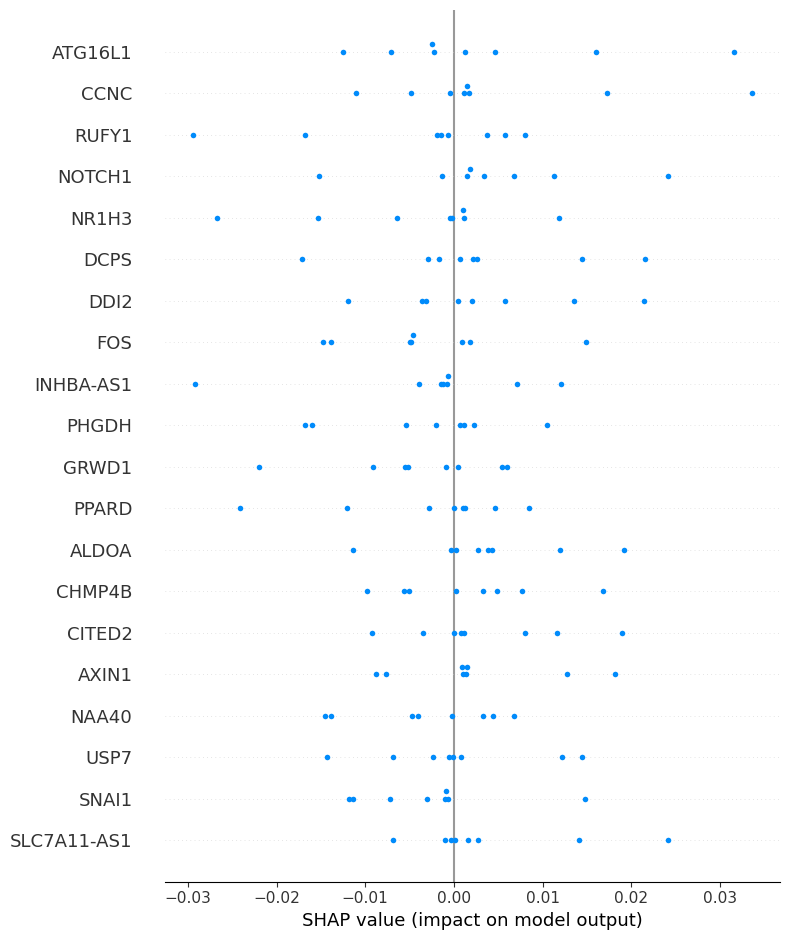

In [26]:
shap.summary_plot(G_shap_values[2][2].T, plot_type='dot', features=STAD_related_gene_symbol_list)

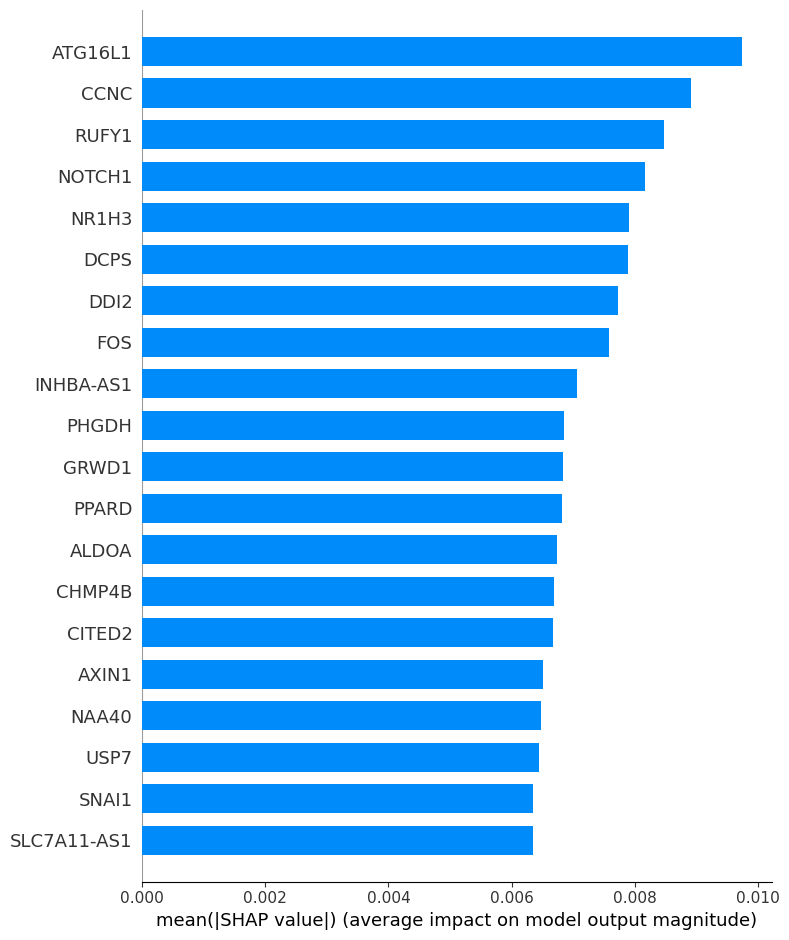

In [21]:
shap.summary_plot(G_shap_values[2][2].T, plot_type='bar', features=STAD_related_gene_symbol_list)